In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn as sk
from datatools import extract_market_data
from pipeline import Dataset

In [3]:
"""load data"""
dataset = Dataset.load('../../data/parsed')
df = pd.concat([dataset.fundamental, extract_market_data(dataset.market)], axis=1).dropna()
return_df = dataset.ref_return

In [4]:
df_with_return = pd.concat([df, return_df], axis=1).dropna()
df_with_return

turnoverRatio  transactionAmount    pe_ttm        pe      pb  \
day asset                                                                 
1   0             3.6794            17229.0   34.4425   32.3029  4.9425   
    1             2.5150             3706.0   28.9934   27.2726  5.0552   
    2             1.2858             5136.0   42.9352   41.9279  4.8083   
    3             2.2007             3280.0   15.2245   13.8032  2.1904   
    4             0.8627             5291.0 -369.9850 -433.1736  3.0714   
...                  ...                ...       ...       ...     ...   
998 49            0.3720             5676.0   41.1121   41.1121  2.8312   
    50            0.4780             4506.0   19.4678   19.4678  2.5076   
    51            1.1501             5179.0   14.5922   14.5922  1.4130   
    52            0.5684             7558.0   28.9922   28.9922  5.7855   
    53            1.2933             9681.0   10.6513   10.6513  1.9956   

               ps       pcf  avg_price  volatility  mean_volume    return  
day asset                                                                  
1   0      3.8180 -578.7700  24.553713    0.861989    454075.84 -0.026877  
    1      3.0484   23.8260  16.169781    0.804576    176868.36 -0.052674  
    2      4.1392  -58.2185   9.059178    0.351893    361648.66 -0.002691  
    3      0.6691   61.0491   9.124460    0.250697    351809.54 -0.018515  
    4      2.9370  -25.2279   5.054415    0.270981    338476.86 -0.019184  
...           ...       ...        ...         ...          ...       ...  
998 49     1.0491   73.1850  13.912934    0.511882    108894.60 -0.014799  
    50     1.1590  -38.0915  11.220278    0.701618     82457.26  0.012921  
    51     0.7009   19.5205   3.743402    0.323547    390835.44 -0.052286  
    52     3.7150 -582.4621  28.845564    0.803932     97800.88 -0.015559  
    53     0.4073  134.5467   9.821027    0.542088    252827.46 -0.003662  

[53892 rows x 11 columns]

In [5]:
new_df = df[(df.index.get_level_values('day') != 999) & (df.index.get_level_values('day') != 1000)]
new_df['log_avg_price'] = np.log(new_df['avg_price'])

C:\Users\specf\AppData\Local\Temp\ipykernel_29384\96619871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['log_avg_price'] = np.log(new_df['avg_price'])


In [6]:
asset_0_df = new_df[new_df.index.get_level_values('asset') == 0]
asset_0_df
asset_0_return = return_df[return_df.index.get_level_values('asset') == 0]
asset_0_return
asset_0_df = asset_0_df.drop(columns=['avg_price'])
asset_0_df

,,turnoverRatio,transactionAmount,pe_ttm,pe,pb,ps,pcf,volatility,mean_volume,log_avg_price
day,asset,,,,,,,,,,
1,0,3.6794,17229.0,34.4425,32.3029,4.9425,3.8180,-578.7700,0.861989,454075.84,3.200863
2,0,3.2535,18378.0,33.3198,31.2498,4.7814,3.6935,-559.9031,2.243321,401517.02,3.174435
3,0,2.4947,13686.0,23.3887,23.3887,4.3823,2.9722,-42.8676,0.522122,307969.24,3.162331
4,0,4.5625,22587.0,23.9187,23.9187,4.4816,3.0396,-43.8390,2.372700,563240.50,3.172805
5,0,18.2257,65239.0,25.9119,25.9119,4.8551,3.2929,-47.4923,4.485819,2249971.94,3.263191
...,...,...,...,...,...,...,...,...,...,...,...
994,0,1.6115,12228.0,64.3030,64.3030,1.6555,1.5626,-41.3480,0.333513,330810.62,2.516958
995,0,1.4651,10464.0,63.6287,63.6287,1.6382,1.5462,-40.9144,0.455761,300758.86,2.516232
996,0,1.7045,10106.0,62.5867,62.5867,1.6113,1.5208,-40.2444,0.556307,349902.24,2.515440


In [63]:
"""implement a function that use ridge kernel regression"""
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor

def ridge_kernel_regression(X, y, alpha, gamma):
    clf = KernelRidge(alpha=alpha, kernel='linear', gamma=gamma)
    clf.fit(X, y)
    return clf


In [64]:
"""print the in-sample R^2 score for clf"""
from sklearn.metrics import r2_score

y_pred = clf.predict(asset_0_df.to_numpy())
print(r2_score(asset_0_return.to_numpy(), y_pred))
df_with_return['log_avg_price'] = np.log(df_with_return['avg_price'])

features = list(new_df.columns)
features.remove('avg_price')
features


0.03163808267481327


['turnoverRatio',
 'transactionAmount',
 'pe_ttm',
 'pe',
 'pb',
 'ps',
 'pcf',
 'volatility',
 'mean_volume',
 'log_avg_price']

In [65]:
from pipeline.backtest import cross_validation, SupportsPredict
from visualization.metric import plot_performance

print(isinstance(clf, SupportsPredict))
performance_ev, comparison = cross_validation(lambda X, y: ridge_kernel_regression(X, y, 0.1, None), list(set(features) - {'transactionAmount', 'meanVolume'}),  df = df_with_return.query("asset<2"), n_splits= 997, lookback_window=50)


True


  0%|          | 0/997 [00:00<?, ?it/s]

Skipping this fold since we cannot truncate the last day.


-0.33367951527291106
PearsonRResult(statistic=0.018966021657515493, pvalue=0.39967767944242444)


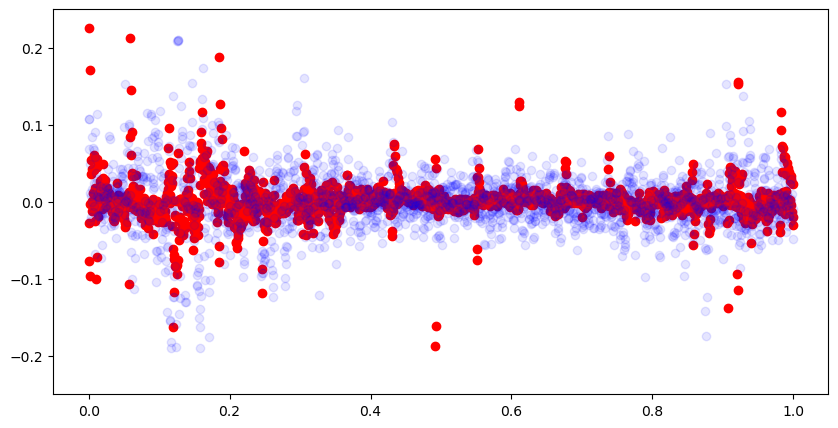

In [66]:

"""clean the outlier"""
comparison = comparison[comparison['cum_y_val_prediction'] < 0.25]
comparison = comparison[comparison['cum_y_val_prediction'] > -0.25]
x = np.linspace(0, 1, len(comparison))
"""compute the R^2 between the prediction and the true value"""
from sklearn.metrics import r2_score
print(r2_score(comparison['cum_y_val_true'], comparison['cum_y_val_prediction']))
"""compute the pearson correlation between the prediction and the true value"""
from scipy.stats import pearsonr
print(pearsonr(comparison['cum_y_val_true'], comparison['cum_y_val_prediction']))

plt.figure(figsize=(10, 5))
plt.scatter(x, comparison['cum_y_val_prediction'], color = 'red')
plt.scatter(x, comparison['cum_y_val_true'], color = 'blue', alpha = 0.1)
plt.ylim(-0.25, 0.25)
plt.show()



In [ ]:
plt.figure(figsize=(10, 5))
plot_performance(performance_ev, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])
plt.ylim(-1, 1)
plt.show()